In [ ]:
6q1from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


## **Importing required Libraries**

In [ ]:
# importing the libraries

import pandas as pd
import numpy as np
import shutil,os


In [ ]:
# for reading and displaying images

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, LeakyReLU, Tanh, AvgPool2d
from torch.optim import Adam, SGD


## **Data Engineering**

In [ ]:
# options: original, 10days, 50days, more_stocks, shorter_intervals
folder = "more_stocks"

In [ ]:
# loading dataset (80:20)
train = pd.read_csv("/content/drive/MyDrive/TrainSet.csv", index_col='id') #Change this to your directory
val= pd.read_csv('/content/drive/MyDrive/validationSet.csv'.format(folder),index_col='id')
train.head()

,target
id,
a213a040-4c6d-4df8-a934-5e4bda91c721.png,0
23262e19-a1f1-44ed-b482-39803600fde5.png,1
c9ce9cff-f96e-40f9-b457-2e85cc7a0efa.png,0
8b39198f-31a6-4555-b6ee-db8cba2627da.png,0
ab6dd1df-cd7d-4b33-b3f7-ee7da301dbb8.png,1


In [ ]:
#Reshaping train images into 64x64 and creating the train_target
import PIL
from PIL import Image
train_target=[]

# options: whole, upper, lower, enlarge, reduce
use_image = "whole"
train_img_directory='/content/drive/MyDrive/Train_images/'
train_new_img_dir='/content/drive/MyDrive/Train_new_images/'

for subdir,dirs,files in os.walk(train_new_img_dir):
  dirs[:] = [folder]
  for file in files:
    os.remove(os.path.join(subdir, file))
      
for subdir,dirs,files in os.walk(train_img_directory):
    dirs[:] = [folder]
    for file in files:
      im= Image.open(subdir+file)
      if use_image == "enlarge":
        im=im.resize((128,128),PIL.Image.ANTIALIAS)
      elif use_image == "reduce":
        im=im.resize((32,32),PIL.Image.ANTIALIAS)
      else:
        im=im.resize((64,64),PIL.Image.ANTIALIAS)
      im.save(train_new_img_dir+file)

for subdir,dirs,files in os.walk(train_new_img_dir):
    for file in files:
      # print(file)
      train_target.append(train.loc[file])

In [ ]:
#Reshaping validation images into 64x64 and creating the validation_target
val_target=[]
val_img_directory='/content/drive/MyDrive/Val_images/'
val_new_img_dir='/content/drive/MyDrive/Val_new_images/'

for subdir,dirs,files in os.walk(val_new_img_dir):
  dirs[:] = [folder]
  for file in files:
    os.remove(os.path.join(subdir, file))

for subdir,dirs,files in os.walk(val_img_directory):
    dirs[:] = [folder]
    for file in files:
      im= Image.open(subdir+file)
      if use_image == "enlarge":
        im=im.resize((128,128),PIL.Image.ANTIALIAS)
      elif use_image == "reduce":
        im=im.resize((32,32),PIL.Image.ANTIALIAS)
      else:
        im=im.resize((64,64),PIL.Image.ANTIALIAS)
      im.save(val_new_img_dir+file)

for subdir,dirs,files in os.walk(val_new_img_dir):
    for file in files:
      # print(file)
     val_target.append(val.loc[file])


In [ ]:
# loading training images
train_img = []
train_directory='/content/drive/MyDrive/Train_new_images/'
for subdir,dirs,files in os.walk(train_directory):
  dirs[:] = [folder]
  for file in files:
    img = imread(subdir+file, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)

if use_image == "lower":
  train_x = train_x[:,43:59,4:58]
  train_x = np.pad(train_x,[(0,0),(43,5),(4,6)])

elif use_image == "upper":
  train_x = train_x[:,:39,4:58]
  train_x = np.pad(train_x,[(0,0),(0,25),(4,6)])

# defining the target
train_y = np.array(train_target)

print(train_x.shape)
print(train_y.shape)


(188, 64, 64)
(188, 1)


In [ ]:
# loading Validation images
val_img = []
val_img_directory='/content/drive/MyDrive/Val_new_images/'
for subdir,dirs,files in os.walk(val_img_directory):
  dirs[:] = [folder]
  for file in files:
    img = imread(subdir+file, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    val_img.append(img)

# converting the list to numpy array
val_x = np.array(val_img)

if use_image == "lower":
  val_x = val_x[:,43:59,4:58]
  val_x = np.pad(val_x,[(0,0),(43,5),(4,6)])

elif use_image == "upper":
  val_x = val_x[:,:39,4:58]
  val_x = np.pad(val_x,[(0,0),(0,25),(4,6)])

# defining the target
val_y = np.array(val_target)

print(val_x.shape)
print(val_y.shape)

(47, 64, 64)
(47, 1)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcff44e3d30>,
 <matplotlib.image.AxesImage at 0x7fcff44d1518>)

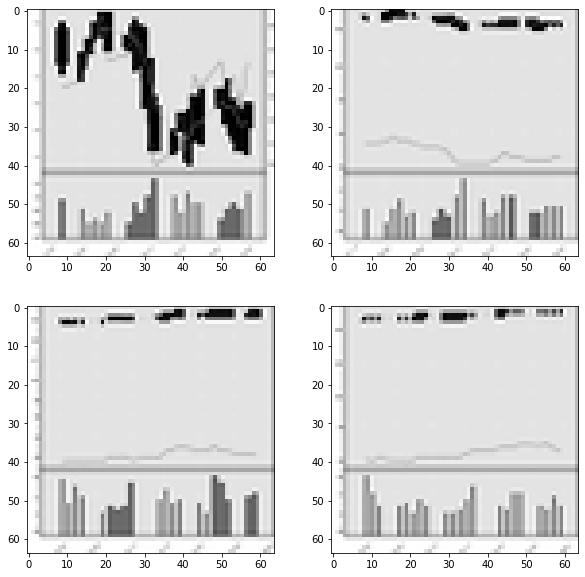

In [ ]:
# visualizing images

i = 0

plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

### **Converting Images to Torch Format**

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# configuration
train_size = train_x.shape[0]
train_shape = train_x.shape[1]
val_size = val_x.shape[0]
val_shape = val_x.shape[1]

In [ ]:
# # converting training images into torch format
train_x = train_x.reshape(train_size, 1, train_shape, train_shape)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

# converting validation images into torch format
val_x = val_x.reshape(val_size, 1, val_shape, val_shape)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape


(torch.Size([47, 1, 64, 64]), torch.Size([47, 1]))

In [ ]:
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

((torch.Size([188, 1, 64, 64]), torch.Size([188, 1])),
 (torch.Size([47, 1, 64, 64]), torch.Size([47, 1])))

In [ ]:
#data processing for batch data loader
class Data(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = Data(torch.FloatTensor(train_x), 
                       torch.FloatTensor(train_y.float()))

val_data = Data(torch.FloatTensor(val_x), 
                       torch.FloatTensor(val_y.float()))

## **Defining Convolution Neural Network**

In [ ]:
#CNN Architecture 

import torch.nn as nn
import torch.nn.functional as F

class Net2(Module):
    def __init__(self):
      super(Net2, self).__init__()
      #we define convolutional layers 
      self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride= 1, padding = 1)
      self.bn1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
      self.bn2 = nn.BatchNorm2d(64)
      self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride=1, padding = 1)
      self.bn3 = nn.BatchNorm2d(128)
      self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride=1, padding = 1)
      self.bn4 = nn.BatchNorm2d(256)

      #2 fully connected layers to transform the output of the convolution layers to the final output
      self.fc1 = nn.Linear(in_features = 4*4*256, out_features = 64)
      self.fcbn1 = nn.BatchNorm1d(64)
      self.fc2 = nn.Linear(in_features = 64, out_features = 1)       
      self.dropout_rate = 0.1

    def forward(self, s):
      #we apply the convolution layers, followed by batch normalisation, 
      #maxpool and relu x 3
      s = self.bn1(self.conv1(s))        # batch_size x 32 x 64 x 64
      s = F.relu(F.max_pool2d(s, 2))     # batch_size x 32 x 32 x 32
      s = self.bn2(self.conv2(s))        # batch_size x 64 x 32 x 32
      s = F.relu(F.max_pool2d(s, 2))     # batch_size x 64 x 16 x 16
      s = self.bn3(self.conv3(s))        # batch_size x 128 x 16 x 16
      s = F.relu(F.max_pool2d(s, 2))     # batch_size x 128 x 8 x 8
      s = self.bn4(self.conv4(s))        # batch_size x 256 x 8 x 8
      s = F.relu(F.max_pool2d(s, 2))     # batch_size x 256 x 4 x 4

      #flatten the output for each image
      s = s.view(-1, 4*4*256) 

      #apply 2 fully connected layers with dropout
      s = F.dropout(F.relu(self.fcbn1(self.fc1(s))), 
      p=self.dropout_rate, training=self.training)    
      s = self.fc2(s)                                     
      return s
      #return F.log_softmax(s, dim=1)

### **Creating CNN model**

In [ ]:
from torch.optim import Adam
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
# Check if gpu support is available
cuda_avail = torch.cuda.is_available()

# Create model, optimizer and loss function
model =Net2()

#if cuda is available, move the model to the GPU
if cuda_avail:
    model.cuda()

#Define the optimizer and loss function
optimizer_adam = Adam(model.parameters(), lr=0.001,weight_decay=1e-4)  #adam optimizer
optimizer_sgd = SGD(model.parameters(), lr=0.001, momentum=0.9)  #SGD optimizer
#scheduler = StepLR(optimizer_adam, step_size=1, gamma=0.1) #adam scheduler 
scheduler = StepLR(optimizer_sgd, step_size=5, gamma=0.1). #SGD scheduler 
loss_BCE = nn.BCEWithLogitsLoss() #binary cross entropy loss
#loss_CE = nn.CrossEntropyLoss() #cross entropy loss
print(model)

Net2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fcbn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
def get_accuracy(y_pred, y_test):          #computes accuracy for model predictions
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True) #dataloader for batch data processing 
val_loader = DataLoader(dataset=val_data, batch_size=64)

In [ ]:
def train(epochs):
    model.train()
    train_losses = []
    train_accuracy = []
    val_accuracy = []
    Epoch=[]
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_val = x_val.cuda()
    y_val = y_val.cuda()
    # prediction for training and validation set
    for epoch in range(epochs):
      Epoch.append(epoch)
     # scheduler.step()
      for X_batch, y_batch in train_loader:  #for every batch of the whole training dataset
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        output_train = model(X_batch) #pass train batch into model
        loss_train = loss_BCE(output_train, y_batch.float()) #compute training loss
        loss_train.backward() #back proganate loss
        optimizer_adam.step() #update parameters based on loss
        optimizer_adam.zero_grad() #zero gradient the optimizer
        #optimizer_sgd.step()
        #optimizer_sgd.zero_grad()
      train_losses.append(loss_train) #append loss for this epoch to a list
      acc_train = get_accuracy(model(x_train),y_train) #get training accuracy for this epoch
      train_accuracy.append(acc_train) #append training accuracy for this epoch to a list
      acc_val = get_accuracy(model(x_val),y_val) #get validation accuracy
      val_accuracy.append(acc_val)
      # computing the updated weights of all the model parameters
      tr_loss = loss_train.item()
      print('Epoch : ',epoch, '\t', 'Train loss :', loss_train,'\t', 'Train accuracy:',acc_train,'\t', 'val accuracy:',acc_val)
    plt.title("Training Accuracy")
    plt.plot(Epoch, train_accuracy, label="Train")
    plt.plot(Epoch, val_accuracy, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Training Accuracy: {}".format(train_accuracy[-1]))
    print("Final Validation Accuracy: {}".format(val_accuracy[-1]))  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch :  0 	 Train loss : tensor(0.7553, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>) 	 Train accuracy: tensor(57., device='cuda:0') 	 val accuracy: tensor(57., device='cuda:0')
Epoch :  1 	 Train loss : tensor(0.6941, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>) 	 Train accuracy: tensor(76., device='cuda:0') 	 val accuracy: tensor(49., device='cuda:0')
Epoch :  2 	 Train loss : tensor(0.6362, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>) 	 Train accuracy: tensor(84., device='cuda:0') 	 val accuracy: tensor(43., device='cuda:0')
Epoch :  3 	 Train loss : tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>) 	 Train accuracy: tensor(89., device='cuda:0') 	 val accuracy: tensor(36., device='cuda:0')
Epoch :  4 	 Train loss : tensor(0.4382, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>) 	 Train accuracy: tensor(94., device='cuda:0') 	 val accuracy: tensor(45., device='cuda:0')
Epoch :  5

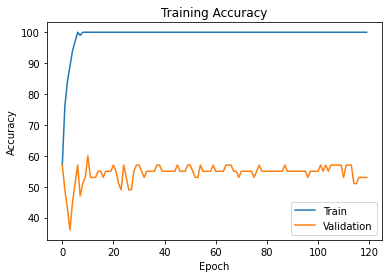

Final Training Loss: 0.003147433279082179
Final Training Accuracy: 100.0
Final Validation Accuracy: 53.0


In [ ]:
train(120)

## **Prediction**

In [ ]:
#prediction for validation set
with torch.no_grad():
    softmax = model(val_x.cuda())
    softmax=softmax.cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
accuracy_score(val_y, predictions)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.55

In [ ]:
#accuracy score on validation set
y_pred_list = []
model.eval()
with torch.no_grad():
        y_test_pred = model(val_x.cuda())
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
      #  y_pred_list.append(y_pred_tag.cpu().numpy())

#y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy_score(val_y,y_pred_tag.cpu())

0.5957446808510638